In [ ]:
# imports
import requests, re, time
import torch, torchvision
from torch import nn, optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

from google.colab import files

In [ ]:
!git clone https://github.com/shirleyqi26/Pokemon

Cloning into 'Pokemon'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 5125 (delta 0), reused 3 (delta 0), pack-reused 5122
Receiving objects: 100% (5125/5125), 818.08 MiB | 47.26 MiB/s, done.
Resolving deltas: 100% (17/17), done.
Checking out files: 100% (5099/5099), done.


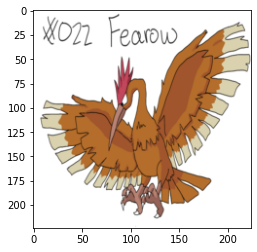

In [ ]:
xform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), torchvision.transforms.RandomHorizontalFlip(p=0.5)])
dataset_full = datasets.ImageFolder('Pokemon/data', transform=xform)
plt.imshow(dataset_full[1234][0].permute(1,2,0))

NOTE: dataset labels are all 1 lower than corresponding pokedex # since it starts from 0. - AJ 

In [ ]:
dataset_full[3220][1]

49

In [ ]:
n_all = len(dataset_full)
n_train = int(0.8 * n_all)
n_test = n_all - n_train
rng = torch.Generator().manual_seed(1549)
dataset_train, dataset_test = torch.utils.data.random_split(dataset_full, [n_train, n_test], rng)

In [ ]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size = 10, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = 10, shuffle=True)

In [ ]:
model = models.resnet50(pretrained=True)
#model.fc = nn.Linear(model.fc.in_features, 75)
#Dylan - below is a version with dropout
model.fc = torch.nn.Sequential(torch.nn.Dropout(0.5),
                               nn.Linear(model.fc.in_features, 75))
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

model.fc.apply(init_weights)

# Dylan - had to do something a little more complicated to initialize it. (there is probably an easier way, I just copied from one of my assignments I did)
#torch.nn.init.xavier_uniform_(model.fc.weight)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  


Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=2048, out_features=75, bias=True)
)

In [ ]:
torch.cuda.device_count()
device = torch.device('cuda:0')
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()

def run_test(model):
    nsamples_test = len(dataset_test)
    loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for samples, labels in loader_test:
            samples = samples.to(device)
            labels = labels.to(device)
            outs = model(samples)
            loss += criterion(outs, labels)
            _, preds = torch.max(outs.detach(), 1)
            correct_mask = preds == labels
            correct += correct_mask.sum(0).item()
    return loss / nsamples_test, correct / nsamples_test

In [ ]:
# Dylan - I added weight decay
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay = 0.035)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.4)

In [ ]:
def run_train(model, opt, sched):
    nsamples_train = len(dataset_train)
    loss_sofar, correct_sofar = 0, 0
    model.train()
    with torch.enable_grad():
        for samples, labels in loader_train:
            samples = samples.to(device)
            labels = labels.to(device)
            opt.zero_grad()
            outs = model(samples)
            _, preds = torch.max(outs.detach(), 1)
            loss = criterion(outs, labels)
            loss.backward()
            opt.step()
            loss_sofar += loss.item() * samples.size(0)
            correct_sofar += torch.sum(preds == labels.detach())
    sched.step()
    return loss_sofar / nsamples_train, correct_sofar / nsamples_train

In [ ]:
def run_all(model, optimizer, scheduler, n_epochs):
    for epoch in range(n_epochs):
        loss_train, acc_train = run_train(model, optimizer, scheduler)
        loss_test, acc_test = run_test(model)
        print(f"epoch {epoch}: train loss {loss_train:.4f} acc {acc_train:.4f}, test loss {loss_test:.4f} acc {acc_test:.4f}")

Running the horizontal flip + random cropping transformations hit 93/91% train/test accuracy. Although, its being tested on transformed images too, so they might not even be great images. -AJ

In [ ]:
#Horizontal flip + random crop
# Dylan- oops I ran it without realizing it had saved the old data before. The data below is now only horizontal flip I think. 
run_all(model, optimizer, scheduler, 10)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch 0: train loss 2.3119 acc 0.4765, test loss 0.0523 acc 0.8764
epoch 1: train loss 0.6409 acc 0.8793, test loss 0.0299 acc 0.9326
epoch 2: train loss 0.3999 acc 0.9402, test loss 0.0263 acc 0.9326
epoch 3: train loss 0.3208 acc 0.9757, test loss 0.0231 acc 0.9520
epoch 4: train loss 0.3264 acc 0.9844, test loss 0.0307 acc 0.9295
epoch 5: train loss 0.2699 acc 0.9944, test loss 0.0209 acc 0.9530
epoch 6: train loss 0.2703 acc 0.9951, test loss 0.0180 acc 0.9632
epoch 7: train loss 0.2909 acc 0.9972, test loss 0.0208 acc 0.9612


KeyboardInterrupt: ignored

In [ ]:
#Horizontal flip
run_all(model, optimizer, scheduler, 20)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch 0: train loss 1.9785 acc 0.5777, test loss 0.0456 acc 0.8795
epoch 1: train loss 0.3693 acc 0.9248, test loss 0.0252 acc 0.9224
epoch 2: train loss 0.1597 acc 0.9765, test loss 0.0183 acc 0.9489
epoch 3: train loss 0.0896 acc 0.9882, test loss 0.0174 acc 0.9551
epoch 4: train loss 0.0562 acc 0.9936, test loss 0.0146 acc 0.9602
epoch 5: train loss 0.0404 acc 0.9974, test loss 0.0143 acc 0.9602
epoch 6: train loss 0.0330 acc 0.9985, test loss 0.0143 acc 0.9571
epoch 7: train loss 0.0333 acc 0.9969, test loss 0.0157 acc 0.9571
epoch 8: train loss 0.0289 acc 0.9992, test loss 0.0143 acc 0.9591
epoch 9: train loss 0.0294 acc 0.9982, test loss 0.0141 acc 0.9591
epoch 10: train loss 0.0298 acc 0.9977, test loss 0.0146 acc 0.9551
epoch 11: train loss 0.0296 acc 0.9985, test loss 0.0150 acc 0.9561
epoch 12: train loss 0.0249 acc 0.9992, test loss 0.0138 acc 0.9612
epoch 13: train loss 0.0260 acc 0.9992, test loss 0.0154 acc 0.9591
epoch 14: train loss 0.0250 acc 0.9992, test loss 0.0151 a

KeyboardInterrupt: ignored

Saving the model

In [ ]:
#Trying to save model
run_all(model, optimizer, scheduler, 5)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch 0: train loss 1.9358 acc 0.5772, test loss 0.0423 acc 0.8815
epoch 1: train loss 0.3704 acc 0.9238, test loss 0.0294 acc 0.9101
epoch 2: train loss 0.1669 acc 0.9724, test loss 0.0173 acc 0.9561
epoch 3: train loss 0.0865 acc 0.9918, test loss 0.0148 acc 0.9612
epoch 4: train loss 0.0579 acc 0.9944, test loss 0.0157 acc 0.9530


In [ ]:
torch.save(model.state_dict(), 'model')

In [ ]:
model1 = models.resnet50(pretrained=True)
model1.fc = nn.Linear(model1.fc.in_features, 75)
model1.to(device)
model1.load_state_dict(torch.load('model'))

<All keys matched successfully>

In [ ]:
optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
run_all(model1, optimizer, scheduler, 1)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch 0: train loss 0.0454 acc 0.9946, test loss 0.0147 acc 0.9581
